# RunTS

`mth5.timeseries.RunTS` is a container to hold multiple synchronous channels of the same sampling rate.  The data is contained in an `xarray.DataSet` which is a collection of `ChannelTS.to_xarray()` objects.  

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS, RunTS
from mt_metadata.timeseries import Electric, Magnetic, Auxiliary, Run, Station

## Create a Run 

We will create a common run that has all 5 channels of an MT measurement (Hx, Hy, Hz, Ex, Ey) plus an auxiliary channel.  We will make individual channels first and then add them into a `RunTS` object. 

In [2]:
channel_list = []
common_start = "2020-01-01T00:00:00"
sample_rate = 8.0
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

### Create `magnetic` channels

In [3]:
for component in ["hx", "hy", "hz"]:
    h_metadata = Magnetic(component=component)
    h_metadata.time_period.start = common_start
    h_metadata.sample_rate = sample_rate
    if component in ["hy"]:
        h_metadata.measurement_azimuth = 90
    h_channel = ChannelTS(
        channel_type="magnetic",
        data=data,
        channel_metadata=h_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(h_channel)
    

### Create `electric` channels

In [4]:
for component in ["ex", "ey"]:
    e_metadata = Electric(component=component)
    e_metadata.time_period.start = common_start
    e_metadata.sample_rate = sample_rate
    if component in ["ey"]:
        e_metadata.measurement_azimuth = 90
    e_channel = ChannelTS(
        channel_type="electric",
        data=data,
        channel_metadata=e_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(e_channel)

### Create `auxiliary` channel

In [5]:
aux_metadata = Auxiliary(component="temperature")
aux_metadata.time_period.start = common_start
aux_metadata.sample_rate = sample_rate
aux_channel = ChannelTS(
        channel_type="auxiliary",
        data=np.random.rand(n_samples) * 30,
        channel_metadata=aux_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
aux_channel.channel_metadata.type = "temperature"
channel_list.append(aux_channel)

2026-01-15T22:32:20.045501-0800 | WARNING | mt_metadata.timeseries.channel | validate_type | line: 315 | Channel type is set to temperature, but should be auxiliary for Auxiliary.


## Create `RunTS` object

Now that we have made individual channels we can make a `RunTS` object by inputing a list of `ChannelTS` objects. 

**Note**: This can also be a list of `xarray.DataArray` objects formated like a channel.

In [6]:
run = RunTS(channel_list)

2026-01-15T22:32:21.204530-0800 | WARNING | mth5.timeseries.run_ts | _validate_array_list | line: 518 | Station ID mt001 from ChannelTS does not match original station ID {self.station_metadata.id}. Updating ID to match.
2026-01-15T22:32:21.221499-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1072 | sample rate of dataset 8.0 is different than metadata sample rate 0.0 updating metatdata value to 8.0


In [7]:
run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:08:31.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

## Plot Run
Again this is a hack at the moment, we are working on a better visualization, but this works for now.

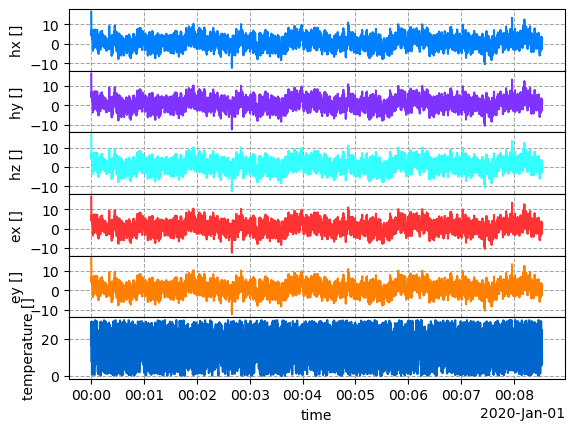

In [8]:
p = run.plot()

## Decimate and Filters

A common practice when working with time series would be decimating or downsampling the data.  `xarray` has some builtins for resampling, however these do not apply a filter prior to downsampling and has alias issues.  We have added some utilities for decimation and filtering following the package [xr-scipy](https://github.com/fujiisoup/xr-scipy/tree/master/xrscipy).  When MTH5 is initiated a `sps_filters` accessor to `xarray.DataArray` and `xarray.Dataset` which includes some filtering methods as well as decimation and resampling.  Therefore for access to these methods use `DataArray.sps_filters.decimate` or `Dataset.sps_filters.decimate`.  

Methods include 

| Name | Function |
|------|----------|
| `lowpass` | low pass filter the data|
| `highpass` | high pass filter the data |
| `bandpass` | band pass filter the data |
| `bandstop` | filter out frequencies using a band stop (notch filter) |
| `decimate` | simulates `scipy.signal.decimate` method by filtering data first then decimating.  Can be inaccurate around the edges of the time series because it assumes periodic signal. |
| `resample_poly` | uses `scipy.signal.resample_poly` method for down sampling, more accurate and usually faster for real signals (default for resampling) |
| `detrend` | uses `scipy.signal.detrend` with keyword `type` to remove trends in the data |  

<div class="alert alert-block alert-info">
<b>Note:</b> In future versions of MTH5 filters will be added to RunTS.
</div>

### Compare Downsampling methods

#### `Decimate`

Here we will decimate to a new sample rate of 1 sample per second.  


In [9]:
decimated_run = run.decimate(1)

2026-01-15T22:32:24.254781-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:08:31+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:08:31+00:00


#### `resample_poly`

`resample_poly` is more accurate for real signals because there is no innate assumption of periodicity.  As you can see in the `decimate` case there are edge effects.  Have a look at the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html) for more information. In the plot below, you'll notice no edge effects and similar numbers as `decimate`. 

<div class="alert alert-block alert-info">
<b>Note:</b> Strongly suggest using `RunTS.resample_poly` for downsampling data.
</div>

In [10]:
resample_poly_run = run.resample_poly(1)

2026-01-15T22:32:24.929783-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:08:31+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:08:31+00:00


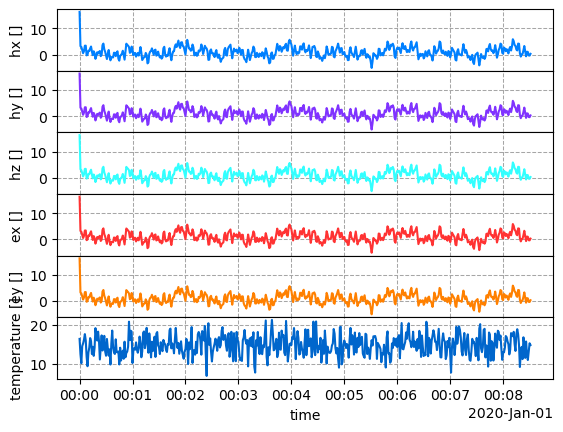

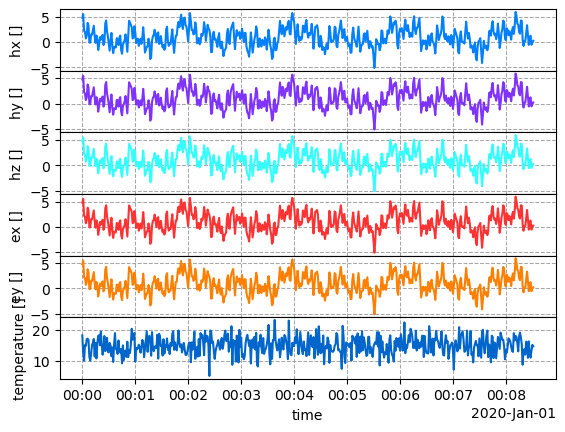

In [11]:
p1 = decimated_run.plot()
p2 = resample_poly_run.plot()

## Merge Runs

It can be benificial to add runs together to create a longer time series.  To combine runs each run must have the same sample rate.  There are 2 builtin options for combining runs 
  
  1. `added_run = run_01 + run_02`
  2. `merged_run = run_01.merge(run_02)` 
  
Both methods use `xarray.combine_by_coords([run1, run2], combine_attrs='override'`.  The `combine_by_coords` method simply concatenates along similar dimensions and cares nothing of a monotonix dimension variable.  Therefore, `xarray.DataSet.reindex` is used to create a monotonically increasing time series.  Any gaps are filled interpolated using a 1-D interpolation.  The default method is `slinear` which is probably the most useful for processing time series.  If you want more control over the interpolation method use `RunTS.merge([run1, run2, ...], gap_method=interpolation_method`.  For more information on interpolation methods see [Scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). Similarly if you want more control on how the datasets are merged use [xarray tools](https://docs.xarray.dev/en/stable/user-guide/combining.html).  

### Using `+`

Using `run_01 + run_02` will combine and interpolate onto a new monotonic time index.  Any gaps will be interpolated linearly interpolated.  If channels are different Nan's will be placed where channels do not overlap.  If you have `hz` in `run_01` but not `run_02` then Nan's will be place in `hz` for the time period of `run_02`.  

In [12]:
for ch in channel_list:
    ch.start = "2020-01-01T00:08:45"
run_02 = RunTS(channel_list)

2026-01-15T22:32:26.953310-0800 | WARNING | mth5.timeseries.run_ts | _validate_array_list | line: 518 | Station ID mt001 from ChannelTS does not match original station ID {self.station_metadata.id}. Updating ID to match.
2026-01-15T22:32:26.962023-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1072 | sample rate of dataset 8.0 is different than metadata sample rate 0.0 updating metatdata value to 8.0


In [13]:
added_run = run + run_02

2026-01-15T22:32:27.023351-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:17:16.875000+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:16.875000+00:00
2026-01-15T22:32:27.023351-0800 | CRITICAL | mth5.timeseries.run_ts | validate_metadata | line: 1061 | sample rate of dataset 8.0 does not match metadata sample rate 1.0 updating metatdata value to 8.0


In [14]:
added_run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:17:16.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

#### Plot combined run

Plotting you can see the linear interpolation in the gap of time between the runs.  Here it makes a spike because the first point in the time series is a spike.

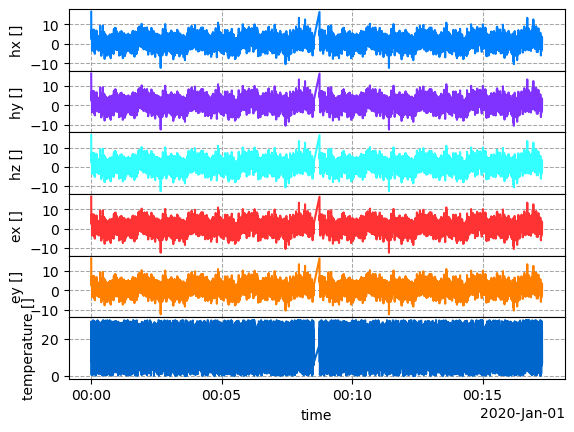

In [15]:
p3 = added_run.plot()

### Using Merge and Decimating

Using `merge` is a little more flexible and many runs can be merged together at the same time.  Note if you use `run_01 + run_02 + run_03` it only combines 2 at a time, which can be inefficient if multiple runs are combined.  `RunTS.merge` provides the option of combining multiple runs and also decimating to lower sample rate with the keyword `new_sample_rate`.

#### Runs with different sample rates

When using merge not all runs need to have the same sample rate, but you need to set `new_sample_rate` to the common sample rate for the combined runs.  This will decimate the data by first applying an iir filter to remove aliasing and then downsample to the desired sample rate.  This mimics [scipy.signal.decimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).   

#### Change interpolation method

To change how gaps are interpolated change the `gap_method` parameter.  See (scipy.interpolate.interp1d)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html]

Options are 

  - ‘linear’
  - ‘nearest’
  - ‘nearest-up’
  - ‘zero’
  - ‘slinear’ (*default*)
  - ‘quadratic’
  - ‘cubic’
  - ‘previous’
  - ‘next’

In [16]:
merged_run = run.merge(run_02, new_sample_rate=1, gap_method="slinear")

2026-01-15T22:32:29.091998-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:08:31+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:08:31+00:00
2026-01-15T22:32:29.140652-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:17:16+00:00 does not match metadata end 2020-01-01T00:17:16.875000+00:00 updating metatdata value to 2020-01-01T00:17:16+00:00
2026-01-15T22:32:29.189537-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1045 | end time of dataset 2020-01-01T00:17:16+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:16+00:00


In [17]:
merged_run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:17:16+00:00
	Sample Rate: 1.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

#### Plot

Plot the merged runs downsampled to 1 second, and the linear interpolation is more obvious. 

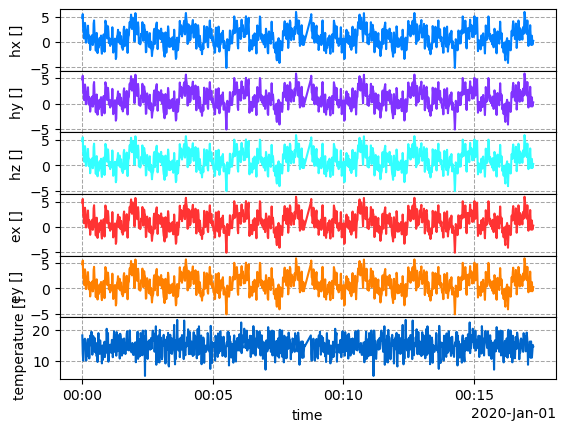

In [18]:
p = merged_run.plot()

## To/From Obspy.Stream

When data is downloaded from an FDSN client or data is collected as miniseed Obspy is used to contain the data as a `Stream` object.  Transformation between `RunTS` and `Stream` is supported.

### To Obspy.Stream

In [19]:
stream = run.to_obspy_stream()

c:\Users\peaco\miniconda3\envs\py311\Lib\site-packages\obspy\core\util\attribdict.py:199: UserWarning: Attribute "network" must be of type <class 'str'>, not <class 'NoneType'>. Attempting to cast None to <class 'str'>
  warnings.warn(msg)


In [20]:
stream

6 Trace(s) in Stream:
None.MT001..MFN | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples
None.MT001..MFE | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples
None.MT001..MFZ | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples
None.MT001..MQN | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples
None.MT001..MQE | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples
None.MT001..MKN | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples

### From Obspy.Stream

In [21]:
new_run = RunTS()
new_run.from_obspy_stream(stream)

2026-01-15T22:32:36.795816-0800 | WARNING | mt_metadata.timeseries.channel | validate_type | line: 315 | Channel type is set to temperature, but should be auxiliary for Auxiliary.
2026-01-15T22:32:36.906202-0800 | WARNING | mth5.timeseries.run_ts | _validate_array_list | line: 518 | Station ID MT001 from ChannelTS does not match original station ID {self.station_metadata.id}. Updating ID to match.
2026-01-15T22:32:36.909148-0800 | WARNING | mth5.timeseries.run_ts | validate_metadata | line: 1072 | sample rate of dataset 8.0 is different than metadata sample rate 0.0 updating metatdata value to 8.0


In [22]:
new_run

RunTS Summary:
	Survey:      0
	Station:     MT001
	Run:         sr8_001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:08:31.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperaturex']